## Libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import nltk
from tqdm import tqdm
from nltk import word_tokenize
nltk.download('punkt')
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
from sklearn.preprocessing import LabelEncoder
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /home/anmol/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/anmol/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Read

In [2]:
f = open("yelp_labelled.txt", "r")
data=list()
texts=list()
labels=list()
while(True):
    line = f.readline()
    if not line:
        break
    x=line.strip()
    x=x.split('\t')
    texts.append(str(x[0]))
    labels.append(int(x[1]))


In [3]:
texts=np.array(texts)
labels=np.array(labels)

In [4]:
print(texts.shape)

(1000,)


In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
sss.get_n_splits(texts, labels)
for train_index, test_index in sss.split(texts, labels):
    train, val = texts[train_index], texts[test_index]
    y_train, y_val = labels[train_index], labels[test_index]


In [6]:
train=pd.DataFrame({'tweet':train , 'labels':y_train})
val=pd.DataFrame({'tweet':val , 'labels':y_val})
val1=val.copy()

In [7]:
print(train.shape , val.shape)

(700, 2) (300, 2)


### Preprocessing data

## steps : 1. tokenize 2. punctuation remove 3.symbols remove 4. removed stop words

In [8]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    text=  word_tokenize(text)  #tokens
    return text
    

In [9]:
for i in range(len(train)):
    train['tweet'].iloc[i]=clean_text(train['tweet'].iloc[i])
for i in range(len(val)):
    val['tweet'].iloc[i]=clean_text(val['tweet'].iloc[i])
       

/home/anmol/.local/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## TRAINING FEATURES

In [10]:
all_words=[]
for i in range(len(train)):
  all_words+=train['tweet'].iloc[i]

from collections import Counter 
count_words = Counter(all_words)
print('feature length' , len(count_words))

total_words=len(all_words)
# print(total_words)
sorted_words=count_words.most_common(total_words)
# print(sorted_words)
vocab_to_int={w:c for i,(w,c) in enumerate(sorted_words)}
# print(vocab_to_int)

corpus=[]
for i in tqdm(range(len(train))):
    rev=[]
    wrd = Counter(train['tweet'].iloc[i])
    for w in vocab_to_int:
        if w in wrd.keys():
            rev.append(wrd[w])
        else:
            rev.append(0)
    corpus.append(rev)
corpus=pd.DataFrame(corpus,columns=vocab_to_int.keys())

 52%|█████▏    | 365/700 [00:00<00:00, 1844.31it/s]

feature length 1603


100%|██████████| 700/700 [00:00<00:00, 1854.76it/s]


In [11]:
corpus

,food,place,good,service,great,back,time,like,go,really,...,hand,pastas,70+,claimed,40,handled,beautifully,gotten,door,services
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
696,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
697,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,0,0,0
698,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


## VALIDATION FEATURES

In [12]:
val_corpus=[]
for i in tqdm(range(len(val))):
    rev=[]
    wrd = Counter(val['tweet'].iloc[i])

    for w in vocab_to_int:
        if w in wrd.keys():
            rev.append(wrd[w])
        else:
            rev.append(0)
    val_corpus.append(rev)
val_corpus=pd.DataFrame(val_corpus,columns=vocab_to_int.keys())

100%|██████████| 300/300 [00:00<00:00, 1724.56it/s]


In [13]:
val_corpus

,food,place,good,service,great,back,time,like,go,really,...,hand,pastas,70+,claimed,40,handled,beautifully,gotten,door,services
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
298,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X_train=corpus
X_val=val_corpus

In [15]:
print('Train matrix',X_train.shape , 'Test matrix', X_val.shape)

Train matrix (700, 1603) Test matrix (300, 1603)


## Model selection 

In [16]:
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report


In [17]:
mnb = MultinomialNB(alpha=1)
y_tr = mnb.fit(X_train, y_train).predict(X_train)
y_pred = mnb.fit(X_train, y_train).predict(X_val)

## Training Accuracy

In [18]:
accuracy_score(y_tr,y_train)

0.9485714285714286

In [19]:
print(classification_report(y_tr, y_train,target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       358
           1       0.94      0.96      0.95       342

    accuracy                           0.95       700
   macro avg       0.95      0.95      0.95       700
weighted avg       0.95      0.95      0.95       700



## Validation Accuracy

In [20]:
accuracy_score(y_pred,y_val)

0.7833333333333333

In [21]:
print(classification_report(y_val, y_pred,target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78       150
           1       0.78      0.79      0.78       150

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.78      0.78      0.78       300



## Mislabelled Points

In [22]:
print("Number of mislabeled points out of a total %d points : %d"% (X_val.shape[0], (y_val != y_pred).sum()))

Number of mislabeled points out of a total 300 points : 65


In [23]:
np.unique(val1[y_val != y_pred]['labels'] , return_counts=True)

(array([0, 1]), array([33, 32]))

In [24]:
np.unique(val1[y_val == y_pred]['labels'] , return_counts=True)

(array([0, 1]), array([117, 118]))

In [25]:
val[y_val != y_pred]['tweet']

5                               [place, honestly, blown]
6               [opened, sandwich, impressed, good, way]
11                                   [assure, ill, back]
31     [one, places, phoenix, would, definately, go, ...
34               [things, went, wrong, burned, saganaki]
                             ...                        
287    [bit, sweet, really, spicy, enough, lacked, fl...
290                       [really, like, crepe, station]
294                                 [wont, disappointed]
295                             [place, deserves, stars]
296      [server, super, nice, checked, us, many, times]
Name: tweet, Length: 65, dtype: object

In [26]:
x1,y1=np.unique(val[y_val != y_pred]['tweet'].apply(len),return_counts=True)

In [27]:
x2,y2=np.unique(val[y_val == y_pred]['tweet'].apply(len),  return_counts=True)

<BarContainer object of 13 artists>

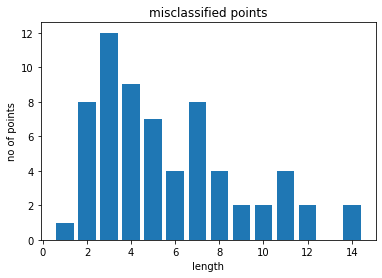

In [28]:
plt.title('misclassified points')
plt.xlabel('length')
plt.ylabel('no of points')
plt.bar(x1,y1)

<BarContainer object of 16 artists>

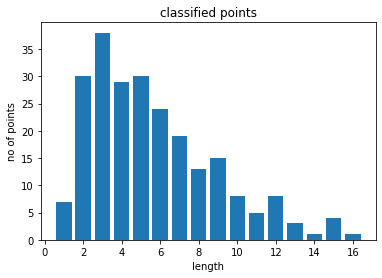

In [29]:
plt.title('classified points')
plt.xlabel('length')
plt.ylabel('no of points')
plt.bar(x2,y2)